<a href="https://colab.research.google.com/github/RoccoGiugni/ASML-24-25/blob/main/L17/L17.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EXERCISE 13 - Supernovae distances and redshifts

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$\mu = m - M = 5\log_{10}(\frac{d_L}{pc}) - 5$

## IMPORT MODULES

In [ ]:
# Install packages if working in colab
!pip install astroML
!pip install emcee
!pip install corner
!pip install dynesty

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.9/102.9 kB 9.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import uniform, loguniform, norm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.linear_model import LinearRegression as skLR

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel

from sklearn.neighbors import KernelDensity

from astroML.datasets import generate_mu_z
from astroML.linear_model import LinearRegression, PolynomialRegression, BasisFunctionRegression, NadarayaWatson

import emcee
import corner

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import resample_equal

/usr/local/lib/python3.12/dist-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


# L17 - PART 1:

## Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

### OPTIONAL

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

# 1 - FIT

In [ ]:
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

In [ ]:
# Data set-up

X = z_sample.copy()
X = X[:, None]

y = mu_sample.copy()
dy = dmu.copy()

z_range = [0.01, 2] # [z_sample.min(), z_sample.max()]
X_pred = np.linspace(z_range[0], z_range[1], 1000)[:, None]

## Linear Regression

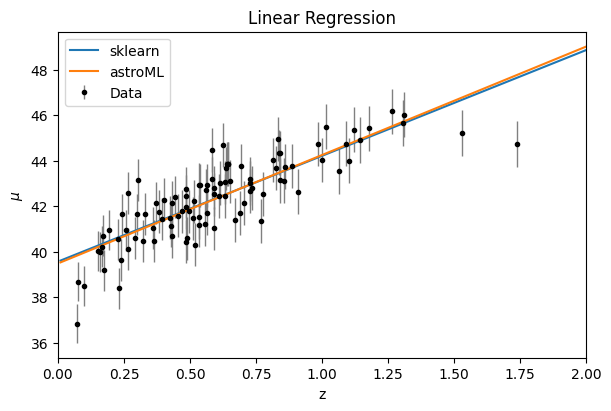

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

lr = skLR()
lr.fit(X, y)
y_pred = lr.predict(X_pred)

ax.plot(X_pred, y_pred, label='sklearn')

lr = LinearRegression()
lr.fit(X, y, dy)
y_pred = lr.predict(X_pred)

ax.plot(X_pred, y_pred, label='astroML')

ax.set_xlim(0, 2)
ax.set_ylim(35, 48)

ax.set_title('Linear Regression')
ax.set_xlabel('z')
ax.set_ylabel(r'$\mu$')
ax.legend();

## Polynomial Regression

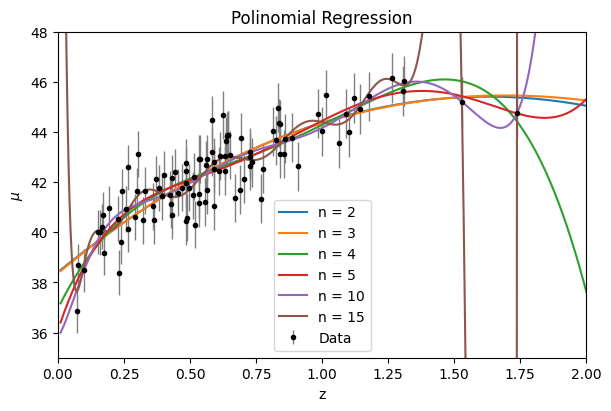

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), sharey=True, layout='constrained')

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

degree = [2, 3, 4, 5, 10, 15] # degree of the polynomials

for n in degree:
    pr = PolynomialRegression(n)
    pr.fit(X, y, dy)
    y_pred = pr.predict(X_pred)
    ax.plot(X_pred, y_pred, label=f'n = {n}')

ax.set_xlim(0, 2)
ax.set_ylim(35, 48)

ax.set_title('Polinomial Regression')
ax.set_xlabel('z')
ax.set_ylabel(r'$\mu$')
ax.legend('lower right');

## Basis Function Regression

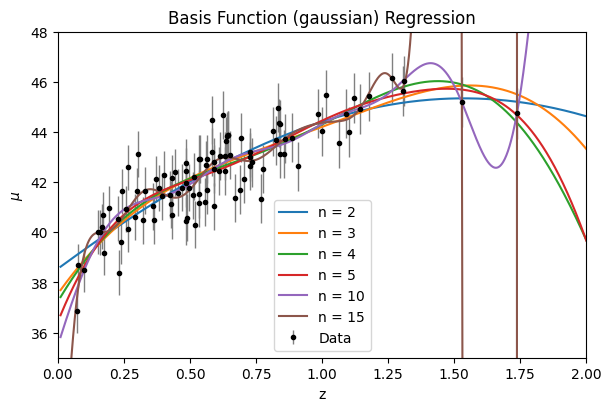

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

gaussian = [2, 3, 4, 5, 10, 15] # number of gaussians

for n in gaussian:
    m = np.linspace(z_range[0], z_range[1], n)[:, None]
    s = m[1] - m[0]

    bfr = BasisFunctionRegression('gaussian', mu=m, sigma=s)
    bfr.fit(X, y, dy)
    y_pred = bfr.predict(X_pred)
    ax.plot(X_pred, y_pred, label=f'n = {n}')

ax.set_xlim(0, 2)
ax.set_ylim(35, 48)

ax.set_title('Basis Function (gaussian) Regression')
ax.set_xlabel('z')
ax.set_ylabel(r'$\mu$')
ax.legend('lower right');

## Kernel Regression (Nadaraya-Waston)

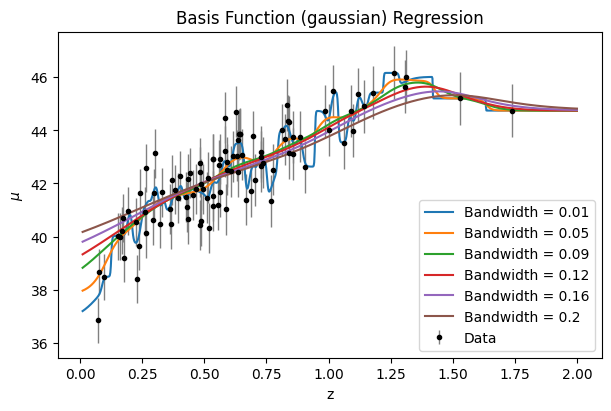

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4), layout='constrained')

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

bandwidth = np.round(np.linspace(.01, .2, 6), 2)

for bw in bandwidth:
    kr = NadarayaWatson('gaussian', bw)
    kr.fit(X, y, dy) # NOTE: here dy is irrelevant
    y_pred = kr.predict(X_pred)
    ax.plot(X_pred, y_pred, label=f'Bandwidth = {bw}')

ax.set_xlim(0, 2)
ax.set_ylim(35, 48)

ax.set_title('Basis Function (gaussian) Regression')
ax.set_xlabel('z')
ax.set_ylabel(r'$\mu$')
ax.legend();

# 2 - CROSS VALIDATION

In [ ]:
## --- FUNCTIONS --- ##

def rms_err(x_obs, x_exp):
    return np.sqrt(np.sum((x_obs - x_exp)**2) / len(x_obs))

def cv_err(X, y, dy, regressor, K=5):
    kf = KFold(n_splits=K, shuffle=True, random_state=42) # DEFAULT: 5-fold cv

    trn_err, tst_err = np.empty(K), np.empty(K)
    for i, index in enumerate(kf.split(X)):
        regressor.fit(X[index[0]], y[index[0]], dy[index[0]])

        trn_err[i] = rms_err(y[index[0]], regressor.predict(X[index[0]])) # training split error
        tst_err[i] = rms_err(y[index[1]], regressor.predict(X[index[1]])) # test split error

    return trn_err, tst_err

/usr/local/lib/python3.12/dist-packages/astroML/linear_model/kernel_regression.py:52: RuntimeWarning: invalid value encountered in divide
  return (K * self.y).sum(1) / K.sum(1)


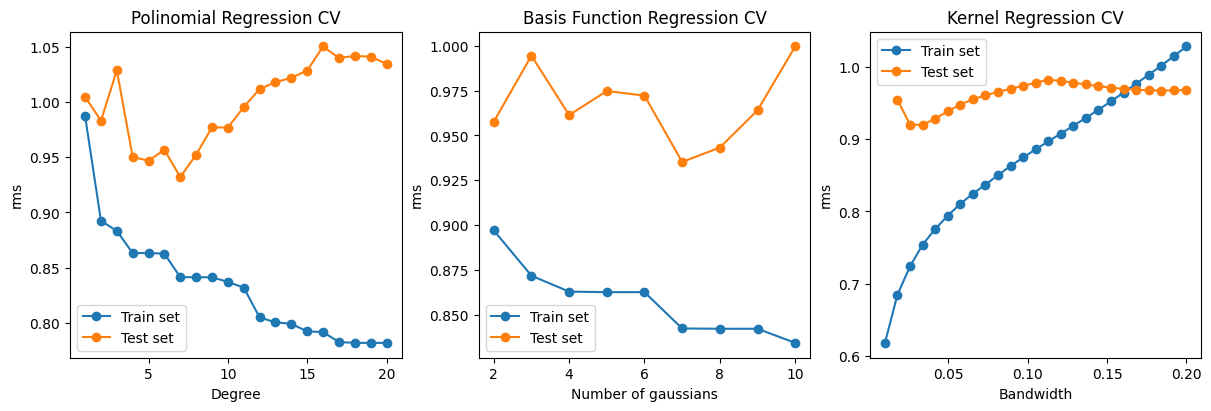

In [ ]:
fig, (ax, bx, cx) = plt.subplots(1, 3, figsize=(12, 4), layout='constrained')

degree, gaussian, bandwidth = np.arange(20) + 1, np.arange(1, 10) + 1, np.linspace(.01, .2, 25)

# -- Polynomial Regression

trn_err, tst_err = np.empty(len(degree)), np.empty(len(degree))
for i, n in enumerate(degree):
    trn, tst = cv_err(X, y, dy, PolynomialRegression(n))
    trn_err[i] = np.median(trn)
    tst_err[i] = np.median(tst)

ax.plot(degree, trn_err, 'o-', label='Train set')
ax.plot(degree, tst_err, 'o-', label='Test set')

ax.set_title('Polinomial Regression CV')
ax.set_xlabel('Degree')
ax.set_ylabel('rms')
ax.legend()

# -- Basis Function Regression

trn_err, tst_err = np.empty(len(gaussian)), np.empty(len(gaussian))
for i, n in enumerate(gaussian):
    m = np.linspace(z_range[0], z_range[1], n)[:, None]
    s = m[1] - m[0]

    trn, tst = cv_err(X, y, dy, BasisFunctionRegression('gaussian', mu=m, sigma=s))
    trn_err[i] = np.median(trn)
    tst_err[i] = np.median(tst)

bx.plot(gaussian, trn_err, 'o-', label='Train set')
bx.plot(gaussian, tst_err, 'o-', label='Test set')

#bx.set_ylim(0, 20)

bx.set_title('Basis Function Regression CV')
bx.set_xlabel('Number of gaussians')
bx.set_ylabel('rms')
bx.legend()

# -- Kernel Regression (Nadaraya-Waston)

trn_err, tst_err = np.empty(len(bandwidth)), np.empty(len(bandwidth))
for i, bw in enumerate(bandwidth):
    trn, tst = cv_err(X, y, dy, NadarayaWatson('gaussian', bw))
    trn_err[i] = np.median(trn)
    tst_err[i] = np.median(tst)

cx.plot(bandwidth, trn_err, 'o-', label='Train set')
cx.plot(bandwidth, tst_err, 'o-', label='Test set')

cx.set_title('Kernel Regression CV')
cx.set_xlabel('Bandwidth')
cx.set_ylabel('rms')
cx.legend();

# 3 - LEARNING CURVES

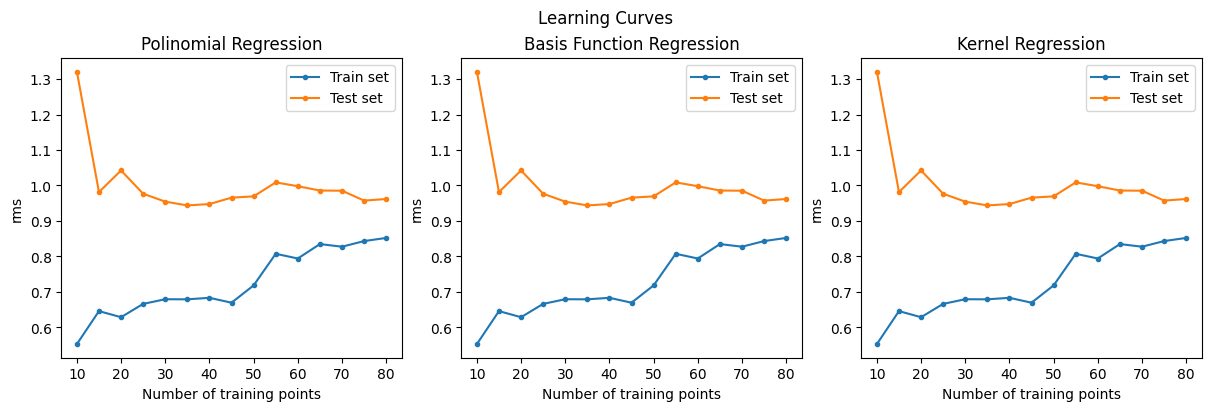

In [ ]:
fig, (ax, bx, cx) = plt.subplots(1, 3, figsize=(12, 4), layout='constrained')
fig.suptitle('Learning Curves')

N, dN = int(.8 * X.shape[0]), 5
trn_points = np.arange(10, N + dN, dN)

pr, kr = PolynomialRegression(4), NadarayaWatson('gaussian', .1)
m = np.linspace(z_range[0], z_range[1], 4)[:, None]
s = m[1] - m[0]
bfr = BasisFunctionRegression('gaussian', mu=m, sigma=s)

trn_err = np.empty((len(trn_points), 3))
tst_err = np.empty((len(trn_points), 3))
for i, n in enumerate(trn_points):
    pr.fit(X[:n], y[:n], dy[:n])
    trn_err[i, 0] = rms_err(y[:n], pr.predict(X[:n]))
    tst_err[i, 0] = rms_err(y[N:], pr.predict(X[N:]))

    bfr.fit(X[:n], y[:n], dy[:n])
    trn_err[i, 1] = rms_err(y[:n], bfr.predict(X[:n]))
    tst_err[i, 1] = rms_err(y[N:], bfr.predict(X[N:]))

    kr.fit(X[:n], y[:n], dy[:n])
    trn_err[i, 2] = rms_err(y[:n], kr.predict(X[:n]))
    tst_err[i, 2] = rms_err(y[N:], kr.predict(X[N:]))

# -- Polynomial Regression

ax.plot(trn_points, trn_err[:, 0], '.-', label='Train set')
ax.plot(trn_points, tst_err[:, 0], '.-', label='Test set')

ax.set_title('Polinomial Regression')
ax.set_xlabel('Number of training points')
ax.set_ylabel('rms')
ax.legend()

# -- Basis Function Regression

bx.plot(trn_points, trn_err[:, 0], '.-', label='Train set')
bx.plot(trn_points, tst_err[:, 0], '.-', label='Test set')

bx.set_title('Basis Function Regression')
bx.set_xlabel('Number of training points')
bx.set_ylabel('rms')
bx.legend()

# -- Kernel Regression (Nadaraya-Waston)

cx.plot(trn_points, trn_err[:, 0], '.-', label='Train set')
cx.plot(trn_points, tst_err[:, 0], '.-', label='Test set')

cx.set_title('Kernel Regression')
cx.set_xlabel('Number of training points')
cx.set_ylabel('rms')
cx.legend();

# L18 - PART 2:

## Tasks

First let's fit our supernova synthetic data from last time using GPR.

- The key ingredient in getting a good GPR fit is the choice of the kernel and its parameters.
- Radial-basis function kernel (aka squared-exponential kernel) is a standard choice in the GPR world.
- But check out what's available in the kernels submodule of sklearn.gaussian_process
- Plot the expectation value of the fit as well as the resulting 1-$\sigma$
 and 2-$\sigma$
 contours.
- Interpret the results.

NOTE: To start with, feel free to tweak the hyperparameters manually. But, of course, a publication-quality result will require a cross-validation analysis.

The European Space Agency is considering new cosmology-related space mission. They ask you to figure out what science you can do with 10 times more measurement compared to what you have right now. That is: you want to clone your data. We've seen this earlier in the class, but now we can do much much better.

- Think about the pdf of these data in $z$.
- Using your GPR fit, generate a set of $\mu$ measurements that respects the statistical properties of the data you were given.

# 4 - GPR

In [ ]:
## --- CROSS VALIDATION --- ##

kernel = ConstantKernel() * RBF()

par_grid = {
    "kernel__k1__constant_value": loguniform(1e-1, 1e2),
    "kernel__k2__length_scale": loguniform(1e-1, 1e2),
}

gpr = GaussianProcessRegressor(kernel=kernel)
cv = RandomizedSearchCV(gpr, par_grid, n_iter=100, random_state=0)
cv.fit(X, y)

best_par = cv.best_params_
print(' --- Best Parameters ---\n')
print(f'Constant value:\t {best_par["kernel__k1__constant_value"]:.2f}')
print(f'Length scale:\t {best_par["kernel__k2__length_scale"]:.2f}')

 --- Best Parameters ---

Constant value:	 32.65
Length scale:	 0.19


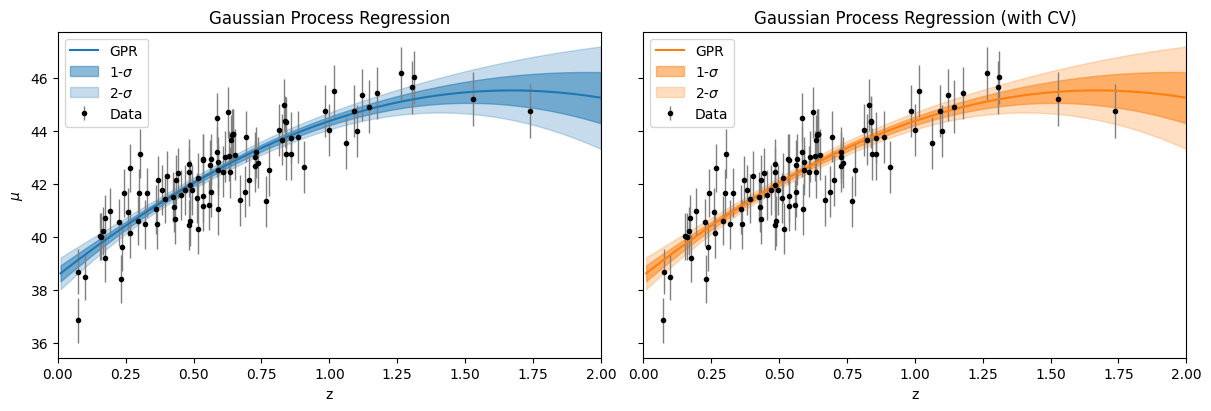

In [ ]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 4), sharey=True, layout='constrained')

ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')
bx.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

# -- no Cross Validation

kernel = ConstantKernel(1, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel, alpha=dy**2)
gpr.fit(X, y)
y_pred, s_pred = gpr.predict(X_pred, return_std=True)

ax.plot(X_pred, y_pred, color='tab:blue', label='GPR')
ax.fill_between(X_pred[:, 0], y_pred - s_pred, y_pred + s_pred,
                color='tab:blue', alpha=.5, label=r'1-$\sigma$')
ax.fill_between(X_pred[:, 0], y_pred - 2 * s_pred, y_pred + 2 * s_pred,
                color='tab:blue', alpha=.25, label=r'2-$\sigma$')

ax.set_xlim(0, 2)

ax.set_title('Gaussian Process Regression')
ax.set_xlabel('z')
ax.set_ylabel(r'$\mu$')
ax.legend();

# -- with Cross Validation

kernel = ConstantKernel(best_par['kernel__k1__constant_value']) * RBF(best_par['kernel__k2__length_scale'])

gpr = GaussianProcessRegressor(kernel=kernel, alpha=dy**2)
gpr.fit(X, y)
y_pred, s_pred = gpr.predict(X_pred, return_std=True)

bx.plot(X_pred, y_pred, color='tab:orange', label='GPR')
bx.fill_between(X_pred[:, 0], y_pred - s_pred, y_pred + s_pred,
                color='tab:orange', alpha=.5, label=r'1-$\sigma$')
bx.fill_between(X_pred[:, 0], y_pred - 2 * s_pred, y_pred + 2 * s_pred,
                color='tab:orange', alpha=.25, label=r'2-$\sigma$')

bx.set_xlim(0, 2)

bx.set_title('Gaussian Process Regression (with CV)')
bx.set_xlabel('z')
bx.legend();

# 5 - MEASURMENTS EXPECTATIONS

In [ ]:
## --- CROSS VALIDATION --- ##

N = 10 # default: 10 parameters iterations
K = 5 # default: 5-folds cross validation

cv = RandomizedSearchCV(KernelDensity(), {'bandwidth': uniform()}, n_iter=N, cv=K)
cv.fit(z_sample[:, None])

best_bw = cv.best_params_['bandwidth']
print(' --- Best Bandwidth ---\n')
print(f'Bandwidth:\t {best_bw:.2f}')

 --- Best Bandwidth ---

Bandwidth:	 0.16


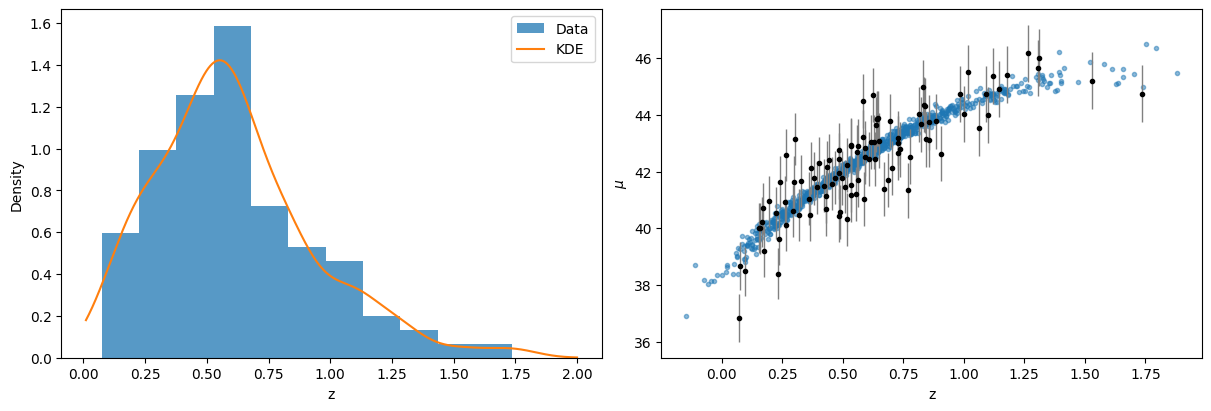

In [ ]:
fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 4), layout='constrained')

ax.hist(z_sample, bins='fd', density=True, alpha=.75, label='Data')

kde = KernelDensity(bandwidth=.1)
kde.fit(z_sample[:, None])

z = np.linspace(z_range[0], z_range[1], 1000)[:, None]
pdf = np.exp(kde.score_samples(z))
ax.plot(z, pdf, label='KDE')

ax.set_xlabel('z')
ax.set_ylabel('Density')
ax.legend()

X_sample = kde.sample(1000)
y_pred, s_pred = gpr.predict(X_sample, return_std=True)
y_sample = norm(y_pred, s_pred).rvs()

bx.scatter(X_sample, y_sample, marker='.', alpha=.5)
bx.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

bx.set_xlabel('z')
bx.set_ylabel(r'$\mu$');

# L18 - PART 3:

## Tasks

For the case of supernovae we also do have a physical theory which is ΛCDM. We can do a parametric fit (and hopehully by now the difference between "parametric" and "data driven" fit is clear in your head)

- First, refresh your cosmology and write down the predicted relationship between the distance module $\mu$ and the redshift $z$. Hint I always forget these things, my to-go reference is Hogg (2010). The answer is:

  $\mu = 5\log\Bigr(\frac{c/H_0}{10\mathrm{pc}}(1+z)\int_0^z\frac{dz'}{\sqrt{\Omega_m(1+z)^3 + \Omega_\Lambda}}\Bigl)$

- Assuming a flat Universe, we have a parametric non-linear model for $\mu(z)$ that depends on two parameters, the Hubble constant $H_0$ and the matter content of the Universe $\Omega_m$

- It's a very non-linear model. Fit it to the data, however you want to do it, using tecniques we've seen throughout the course. Some ideas:

  - Set up a Bayesian framework and use MCMC
  - Set up a fully-connected neural network (see end of the class)

- What are the measured value of $H_0$ and $\Omega_m$. What's they errors? Are they correlated?

- How would a model without dark energy (i.e. $\Omega_m = 1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

# 6 - MCMC

Let's use dynesty

In [ ]:
## --- COSMOLOGICAL MODEL --- ##

from astropy.cosmology import FlatLambdaCDM

def lcdm(par, z):
    H_0, O_m = par

    cosmo = FlatLambdaCDM(H0=H_0, Om0=O_m)
    return cosmo.distmod(z).value

def cdm(par, z):
    (H_0,) = par

    cosmo = FlatLambdaCDM(H0=H_0, Om0=1)
    return cosmo.distmod(z).value

In [ ]:
def pt_lcdm(u):
    u[0] = 60 * u[0] + 40 # prior on H_0
    u[1] *= 1 # prior on O_m

    return u

def logL_lcdm(par):
    mu_exp = lcdm(par, z_sample)

    out = np.log(2 * np.pi * dmu**2) + (mu_exp - mu_sample)**2 / dmu**2
    return -.5 * np.sum(out)

def pt_cdm(u):
    u[0] = 60 * u[0] + 40 # prior on H_0

    return u

def logL_cdm(par):
    mu_exp = cdm(par, z_sample)

    out = np.log(2 * np.pi * dmu**2) + (mu_exp - mu_sample)**2 / dmu**2
    return -.5 * np.sum(out)

In [ ]:
## --- SAMPLER --- ##

print(' --- Static Sampling Inizialized ---\n')
print('Sampling ...')

points = 250 # number of live points. DEFAULT: 250 (in dynesty)

sampler_lcdm = dynesty.NestedSampler(logL_lcdm, pt_lcdm, 2, nlive=points, bootstrap=0)
sampler_lcdm.run_nested()
sampler_cdm = dynesty.NestedSampler(logL_cdm, pt_cdm, 1, nlive=points, bootstrap=0)
sampler_cdm.run_nested()

result_lcdm = sampler_lcdm.results
result_cdm = sampler_cdm.results

print('\nDone\n\n')

logZ_lcdm = result_lcdm.logz[-1]        # value of logZ
logZerr_lcdm = result_lcdm.logzerr[-1]  # estimate of the statistical uncertainty on logZ
logZ_cdm = result_cdm.logz[-1]
logZerr_cdm = result_cdm.logzerr[-1]

print(' --- Results ---\n')
print(f'Marginalised evidence (lcdm)= {logZ_lcdm:.3} ± {logZerr_lcdm:.3}')
print(f'Marginalised evidence (cdm)= {logZ_cdm:.3} ± {logZerr_cdm:.3}')

 --- Static Sampling Inizialized ---

Sampling ...


938it [03:08,  4.97it/s, +250 | bound: 1 | nc: 1 | ncall: 9085 | eff(%): 13.447 | loglstar:   -inf < -132.816 <    inf | logz: -135.102 +/-  0.071 | dlogz:  0.001 >  0.259]
916it [03:09,  4.83it/s, +250 | bound: 1 | nc: 1 | ncall: 9069 | eff(%): 13.221 | loglstar:   -inf < -133.530 <    inf | logz: -135.710 +/-  0.068 | dlogz:  0.001 >  0.259]


Done


 --- Results ---

Marginalised evidence (lcdm)= -1.35e+02 ± 0.125
Marginalised evidence (cdm)= -1.36e+02 ± 0.125


In [ ]:
weights = np.exp(result_lcdm['logwt'] - result_lcdm['logz'][-1])
samples_lcdm = resample_equal(result_lcdm.samples, weights)

mean, cov = dynesty.utils.mean_and_cov(samples_lcdm, weights)
print('Mean and covariance of parameters are: ' + str(mean) + '\n' + str(cov))

Mean and covariance of parameters are: [66.61256552  0.47295624]
[[38.07481613 -1.36418546]
 [-1.36418546  0.06393349]]


## Model Comparison

Bayesian factor:  1.8366413811281777 



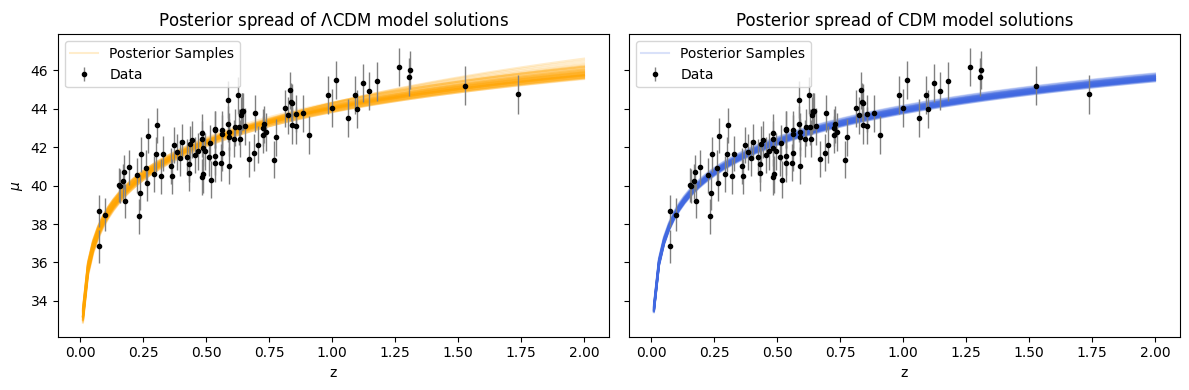

In [ ]:
# -- Bayes Factor
B_12 = np.exp(logZ_lcdm) / np.exp(logZ_cdm)
print('Bayesian factor: ', B_12, '\n')

# Random selection of 50 sets of LCDM parameters (H_0 and O_m)
weights = np.exp(result_lcdm['logwt'] - result_lcdm['logz'][-1])
samples_lcdm = resample_equal(result_lcdm.samples, weights)

index = np.random.choice(len(samples_lcdm), size=50, replace=False)
par_lcdm = samples_lcdm[index]

# Random selection of 50 sets of CDM parameters (H_0)
weights = np.exp(result_cdm['logwt'] - result_cdm['logz'][-1])
samples_cdm = resample_equal(result_cdm.samples, weights)

index = np.random.choice(len(samples_cdm), size=50, replace=False)
par_cdm = samples_cdm[index]

# -- Plotting
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True, layout='tight')

models = [lcdm, cdm]
random_par = [par_lcdm, par_cdm]
title = [r'$\Lambda$CDM', 'CDM']
color = ['orange', 'royalblue']

z_ = np.linspace(z_range[0], z_range[1], 100)
for i, ax in enumerate(axs):
    for j, par in enumerate(random_par[i]):
        y = models[i](par, z_)
        l = "Posterior Samples" if j == 0 else None
        ax.plot(z_, y, color=color[i], alpha=.2, label=l)

    ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='Data')

    ax.set_title('Posterior spread of ' + title[i] + ' model solutions')
    ax.set_xlabel('z')

    ax.legend()

axs[0].set_ylabel(r'$\mu$');